Gets self efficacy and response efficacy score

Preprocessing
==============

Efficacy scores were collected in:
- every 3 days evening questionnaires (!! bug in the plateform, question was presented every day for some participants -> need to work out which and take every 3 day measures)

- baseline and followup efficacy - for EEG participants

- screening and followup questionnaire - get scores for online participants

- Participants who did the baseline and followup Efficacy score on the same survey as the every 3 days one: 
562, 477, 703, 786

In [1]:
library(tidyverse)
library(here)
library(lubridate)

#get filepaths

#eff_evening_filepath = here("Every3days")

cond_file = "~/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/expe_condition_final.csv"


save_figure = here::here("Figures")

#read files

files_eff_eve <-dir(path=here::here("data/Every3days") , pattern = "*.csv") 
files_eff_bf <-dir(path=here::here("data/BaselineFollowup") , pattern = "*.csv") 
files_eff_online<-dir(path=here::here("data/OnlineFollowup") , pattern = "*.csv") 
# use here the data from the pp recruitment files
files_eff_base_online<-dir(path=here::here("data/OnlineBaseline") , pattern = "baseline_eff_score.csv") # sheet with screening ID
files_study_id<-dir(path=here::here("data/OnlineBaseline") , pattern = "study_ids_online.csv") # sheet with screening_id/study_ids corresponsdence
files_qualtrics<-dir(path=here::here("data/OnlineBaseline") , pattern = "qualtrics.csv") # sheet with screening_id/study_ids corresponsdence


every3days_scores <-read.csv(here::here("data/Every3days", files_eff_eve), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
baseline_followup_eeg <-read.csv(here::here("data/BaselineFollowup", files_eff_bf), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
followup_online <-read.csv(here::here("data/OnlineFollowup", files_eff_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
baseline_online <-read.csv(here::here("data/OnlineBaseline", files_eff_base_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
study_id <-read.csv(here::here("data/OnlineBaseline",files_study_id), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
qualtrics <-read.csv(here::here("data/OnlineBaseline",files_qualtrics), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

# condition file
cond <- read_csv(cond_file)


#Associate online pp baseline efficacy score with their study id:


#select only screening ID and qualtrics ID on recruitment file
pp_ids<-baseline_online %>% select("Screening.ID", "Response.ID") 

qualtrics<-rename(qualtrics, Response.ID = ResponseId)


remove(baseline_online)

baseline_online<-left_join(pp_ids, qualtrics, by= 'Response.ID')

# join with study id
baseline_online <- left_join(study_id, baseline_online)

# remove screening id
baseline_online<-select(baseline_online, -Screening.ID)



── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /home/claire/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/Efficacy_scores


Attaching package: ‘lubridate’


The following object is masked from ‘package:here’:

    here


The following object is masked from ‘package:base’:

    date


Parsed with column specification:
cols(
  `Subject ID` = col_double(),
  day_msg = col_double(),
  `Starting Date` = col_character(),
  Good = col_double(),
  `Condition = Intervention` = col_double(),
  EEG = col_double(),
  Finished = col_double(),
  REMOVED = col_double(),
  Interview = col_double(),
  Notes = col_character(),
  `No Compliance` = co

In [2]:
#rename columns 
#- questions scoring: 0 = not at all; 100 = very much

every3days_scores<-rename(every3days_scores , date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1, 
                  quit_int = Q5
                  )

every3days_scores$ID<-as.factor(every3days_scores$ID)


baseline_followup_eeg <-rename(baseline_followup_eeg, date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1
                 # quit_int = Q5
                  )

baseline_followup_eeg$ID<-as.factor(baseline_followup_eeg$ID)


followup_online<-rename(followup_online, date=EndDate, completed=Finished, 
                      ID= Q1, 
                       r_eff1 = Q88_1, r_eff2= Q88_2, 
                       s_eff1 = Q90_1, s_eff2 = Q90_2, s_eff3= Q90_3, 
                       hope=Q92_1
                       )
followup_online$ID<-as.factor(followup_online$ID)

baseline_online<-rename(baseline_online, date=EndDate, completed=Finished, 
                       ID= Study.ID, 
                       r_eff1 = Q108_1, r_eff2= Q108_2, 
                       s_eff1 = Q110_1.1, s_eff2 = Q110_2.1, s_eff3= Q110_3.1, 
                       hope=Q112_1.1
                           )

            
baseline_online$ID<-as.factor(baseline_online$ID)

#Create one long dataset collating all data

# add a "session" column

every3days_scores <- add_column(every3days_scores, "type" = "every3days")
followup_online <- add_column(followup_online, "type" = "followup")
baseline_online<- add_column(baseline_online, "type" = "baseline")

#get sessions for the baseline-followup dataset
  

# remove extra header
#baseline_followup_eeg<-tail(baseline_followup_eeg, -2)

In [3]:
every3days_scores

StartDate,date,Status,Progress,Duration..in.seconds.,completed,RecordedDate,ResponseId,DistributionChannel,UserLanguage,ID,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,quit_int,type
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,Please enter your participant number,Say how much you agree or disagree with the following statements: - How much do you think you would benefit from health and other gains if you were to quit smoking permanently in the next 6 months?,Say how much you agree or disagree with the following statements: - How much would quitting smoking altogether right now reduce your chances of getting a serious illness?,"Say how much you agree or disagree with the following statements: - If I decided to give up smoking completely in the next 6 months, I'm sure I would succeed.",Say how much you agree or disagree with the following statements: - I am confident I could quit smoking altogether right now.,Say how much you agree or disagree with the following statements: - I could easily cut down the number of cigarettes I smoke.,". - When you think about quitting smoking, how hopeful do you feel?",Which of the statements below sounds most like you?,every3days
"{""ImportId"":""startDate"",""timeZone"":""Europe/London""}","{""ImportId"":""endDate"",""timeZone"":""Europe/London""}","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""Europe/London""}","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}","{""ImportId"":""QID1_TEXT""}","{""ImportId"":""QID3_1""}","{""ImportId"":""QID3_2""}","{""ImportId"":""QID4_1""}","{""ImportId"":""QID4_2""}","{""ImportId"":""QID4_3""}","{""ImportId"":""QID7_1""}","{""ImportId"":""QID5""}",every3days
2019-04-11 09:43:59,2019-04-11 09:44:30,0,100,31,1,2019-04-11 09:44:30,R_2PvbGQnsj4eiRpA,anonymous,EN-GB,0,52,97,38,43,47,41,2,every3days
2019-04-13 22:04:37,2019-04-13 22:04:55,0,100,17,1,2019-04-13 22:04:55,R_2RQSpdtM7fX3yX1,anonymous,EN-GB,333,84,75,80,87,69,84,1,every3days
2019-04-23 22:52:13,2019-04-23 22:52:56,0,100,42,1,2019-04-23 22:52:56,R_3L0Cvt2dC1YPLLt,anonymous,EN-GB,558,86,82,55,49,42,76,6,every3days
2019-04-26 12:32:04,2019-04-26 12:32:10,0,20,5,0,2019-04-26 16:32:39,R_803TwExpmb8QiiZ,anonymous,EN-GB,,,,,,,,,every3days
2019-04-26 22:14:12,2019-04-26 22:14:52,0,100,40,1,2019-04-26 22:14:52,R_3L1svwmx3nFxSWB,anonymous,EN-GB,558,72,73,65,49,57,59,4,every3days
2019-04-28 21:02:01,2019-04-28 21:02:26,0,100,25,1,2019-04-28 21:02:26,R_2uQK7LW8U20SQXG,anonymous,EN-GB,558,73,66,64,65,53,62,5,every3days
2019-04-29 05:19:51,2019-04-29 05:21:32,0,100,100,1,2019-04-29 05:21:32,R_1LwKC9kLeHxnNJS,anonymous,EN-GB,278,93,98,49,3,25,29,5,every3days


In [4]:
# create session based on occurrence of ID 
baseline_followup_eeg<-baseline_followup_eeg %>% 
        #mutate(date=ymd_hms(baseline_followup_eeg$date))  %>% 
        group_by(ID)  %>%   
        mutate('type'= row_number()) %>% 
        ungroup()
        
# assign factor and recode        
baseline_followup_eeg$type<-as.factor(baseline_followup_eeg$type)        
baseline_followup_eeg$type<-recode(baseline_followup_eeg$type, '1'="baseline", '2'="followup")                            


# select only columns of interest

baseline_followup_eeg<-select(baseline_followup_eeg, ID, date, r_eff1:hope, type, completed)
every3days_scores <-select(every3days_scores, ID, date, r_eff1:hope, type, completed)
followup_online<-select(followup_online, ID, date, r_eff1:hope, type, completed)
baseline_online<-select(baseline_online, ID, date, r_eff1:hope, type, completed)

# get only completed surveys
#every3days_scores<-filter(every3days_scores, completed=='True')

#baseline_followup_eeg<-filter(baseline_followup_eeg, completed=='True')
#
#followup_online<-filter(followup_online, completed=='True')
#baseline_online<-filter(baseline_online, completed=='True')

#Do some custom change to fit special cases


#---------------------------------#
# get data for the 4 pps who did the baseline and followup efficacy measure in the every3days

ID_add_to_bf <-c(562, 477, 703, 786)

tmp<- every3days_scores %>% 
  filter(ID %in% ID_add_to_bf)

tmp_bf_score <- tmp %>%  # get baseline and follow up scores - 1st and last 
  group_by(ID) %>% 
  slice(c(1, n())) %>% 
  ungroup()  

baseline_followup_eeg<-full_join(baseline_followup_eeg, tmp_bf_score)  # add to df_bf

# remove first and last measures then put back into main df dataframe, remove these ID from df before !

tmp_df <- tmp %>% 
  group_by(ID) %>% 
  slice(2:(n()-1)) %>% 
  ungroup()  

Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”
Warning message:
“Column `type` joining factor and character vector, coercing into character vector”


In [6]:
# remove those ID from df then put them back

every3days_scores<- every3days_scores %>% 
  filter(!ID %in% ID_add_to_bf )

every3days_scores<-full_join(every3days_scores, tmp_df)

rm(tmp, tmp_bf_score, tmp_df)

Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")



In [8]:
# get IDs of pp who did the survey every day instead of every 3 days

# get date format
every3days_scores$date<-ymd_hms(every3days_scores$date)

Warning message:
“ 2 failed to parse.”


In [9]:
# first remove  false alarms (non completed surveys)

every3days_scores<- every3days_scores %>% filter(every3days_scores$completed=='1')

In [ ]:
# add a counter for each row per ID (see 1.)
every3days_scores <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(n_day = row_number()) %>%
  select(ID, n_day, everything()) %>% 
  ungroup()  
every3days_scores$n_day<-as.factor(every3days_scores$n_day)

In [30]:
get_ID_bug <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(count = row_number()) %>% 
  filter(count>9) %>% 
  ungroup()  

In [31]:
get_ID_bug

ID,n_day,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,count
<fct>,<fct>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
558,10,2019-05-14 22:51:08,80,73,80,76,79,71,every3days,1,10
270,10,2019-08-02 09:07:14,100,100,5,0,8,0,every3days,1,10
209,10,2019-08-02 21:23:39,58,65,68,61,79,66,every3days,1,10
270,11,2019-08-03 09:31:52,100,100,1,0,10,0,every3days,1,11
270,12,2019-08-03 21:01:40,100,100,0,0,3,0,every3days,1,12
209,11,2019-08-04 08:38:14,61,69,65,49,80,55,every3days,1,11
312,10,2019-08-04 17:10:22,20,20,0,0,0,24,every3days,1,10
775,10,2019-08-04 21:34:42,74,78,36,39,35,36,every3days,1,10
209,12,2019-08-04 22:08:47,66,81,76,73,85,65,every3days,1,12


In [ ]:
# get pp who were in bug window
# get survey completed at start date + 3 +3 etc...

In [14]:
# get the experiment condition file with all pp IDs
cond <-rename(cond, ID = "Subject ID", condition = "Condition = Intervention", removed= "REMOVED")
cond$ID<-as.factor(cond$ID)


every3days_scores_tmp<-full_join(cond, every3days_scores)

Joining, by = "ID"

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”


In [27]:
# get list of pp who started during bug time window (July/August) 
#ID_bug<-every3days_scores_tmp %>% 
 #           filter(n_day==1) %>% 
 #           filter(date>=as.Date("2019-07-23") & date<=as.Date("2019-08-30") ) 



In [16]:
every3days_scores_tmp <-rename(every3days_scores_tmp , start=`Starting Date`)
every3days_scores_tmp$start<-dmy(every3days_scores_tmp$start)


df_bug<- every3days_scores_tmp %>% 
  filter(start>=as.Date("2019-07-20") & date<=as.Date("2019-08-30")) 


# get unique start dates
all_starts<-unique(df_bug$start)
all_starts



[1] "2019-07-20" "2019-07-23" "2019-07-25" "2019-07-27" "2019-08-10"
[6] "2019-08-09"

In [17]:
# make a loop from n=1 to len(all_starts)
for(n in 1:length(all_starts)){
        # get data for 1st date
        #ndf[n]<-paste("df", n, sep="_")
        # create data frame to store every 3 days and their label
        df_dates= tibble(label_days= 1:9)

        df<-df_bug %>% filter(start==all_starts[n]) 
        # get vector with dates corresponding to start date + every 3 days
        n_dates<-vector() # to store every 3 days dates
        for(i in seq(from=3, to=28, by=3)){
            date<-all_starts[n]+days(i)
            n_dates<-append(n_dates, date)
            }


        df_dates<-add_column(df_dates, date=n_dates)
        df_dates$date<-ymd(df_dates$date)
        df_dates$date<-as.POSIXct(df_dates$date)
        # get corresponding data
        #df<-df %>% filter(as.Date(date) %in% n_dates)
        df$date<-floor_date(df$date, unit="day")

        df<-inner_join(df, df_dates, by="date")

        assign(paste("df", n, sep="_"), df)
    }

In [18]:
df_2

ID,day_msg,start,Good,condition,EEG,Finished,removed,Interview,Notes,⋯,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,label_days
<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-07-29,99,99,58,28,47,59,every3days,1,2
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-08-01,21,6,3,2,50,3,every3days,1,3
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-08-07,87,92,47,44,79,49,every3days,1,5
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-08-10,11,57,41,28,39,13,every3days,1,6
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-08-10,29,83,44,44,48,51,every3days,1,6
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-08-13,77,32,65,66,54,53,every3days,1,7
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-08-16,92,86,72,28,72,70,every3days,1,8
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-08-19,85,62,64,95,86,53,every3days,1,9
599,88,2019-07-23,1,0,0,1,0,NA,NA,⋯,2019-08-19,89,59,90,57,74,88,every3days,1,9


In [19]:
df

ID,day_msg,start,Good,condition,EEG,Finished,removed,Interview,Notes,⋯,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,label_days
<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
724,59,2019-08-09,0,1,0,1,NA,NA,NA,⋯,2019-08-12,65,82,76,86,90,53,every3days,1,1
724,59,2019-08-09,0,1,0,1,NA,NA,NA,⋯,2019-08-18,86,91,53,36,84,75,every3days,1,3


In [20]:
test<-inner_join(df, df_dates, by="date")

In [21]:
test<-floor_date(df$date, unit="day")

In [22]:
test

[1] "2019-08-12 UTC" "2019-08-18 UTC"

In [23]:
df %>% filter(df$date %in% df_dates$date)

ID,day_msg,start,Good,condition,EEG,Finished,removed,Interview,Notes,⋯,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,label_days
<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
724,59,2019-08-09,0,1,0,1,NA,NA,NA,⋯,2019-08-12,65,82,76,86,90,53,every3days,1,1
724,59,2019-08-09,0,1,0,1,NA,NA,NA,⋯,2019-08-18,86,91,53,36,84,75,every3days,1,3


In [24]:
class(df$date)

[1] "POSIXct" "POSIXt"

In [25]:
filter(df_1, df_1$ID==270)

ID,day_msg,start,Good,condition,EEG,Finished,removed,Interview,Notes,⋯,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,label_days
<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
270,89,2019-07-20,1,0,0,1,0,NA,took follow up questionnaire 1 month after end of its experiment,⋯,2019-07-23,100,100,34,0,21,31,every3days,1,1
270,89,2019-07-20,1,0,0,1,0,NA,took follow up questionnaire 1 month after end of its experiment,⋯,2019-07-26,100,55,0,0,20,24,every3days,1,2
270,89,2019-07-20,1,0,0,1,0,NA,took follow up questionnaire 1 month after end of its experiment,⋯,2019-07-29,100,100,0,0,24,1,every3days,1,3
270,89,2019-07-20,1,0,0,1,0,NA,took follow up questionnaire 1 month after end of its experiment,⋯,2019-08-07,100,100,0,0,0,0,every3days,1,6
270,89,2019-07-20,1,0,0,1,0,NA,took follow up questionnaire 1 month after end of its experiment,⋯,2019-08-10,100,100,0,0,8,0,every3days,1,7
270,89,2019-07-20,1,0,0,1,0,NA,took follow up questionnaire 1 month after end of its experiment,⋯,2019-08-13,100,100,0,0,0,0,every3days,1,8
270,89,2019-07-20,1,0,0,1,0,NA,took follow up questionnaire 1 month after end of its experiment,⋯,2019-08-13,100,100,1,10,19,0,every3days,1,8
270,89,2019-07-20,1,0,0,1,0,NA,took follow up questionnaire 1 month after end of its experiment,⋯,2019-08-16,100,100,0,9,9,0,every3days,1,9


In [40]:
  
# for those IDs, only select data from the 1, 6, 9, 12, 15, 18, 21, 24, 27 days, and rename 1:9   
days<-c(1, 6, 9, 12, 15, 18, 21, 24, 27)

# create a new dataframe combining all pps 
df9<- every3days_scores %>% 
  filter(ID %in%get_ID_bug$ID & n_day %in% days) 
  

df9$n_day<-recode_factor(df9$n_day, '1' = "1", '6'="2", '9'="3", '12' ="4", '15'="5", '18'="6", '21'="7", '24'="8", '27'="9")

tmp <- every3days_scores %>% 
filter(!ID %in% (get_ID_bug$ID) )

df9<- rbind(df9, tmp)

In [58]:
# create n_day column for baseline and followup
followup_online <- followup_online %>% mutate(n_day = '10')

baseline_online <- baseline_online %>% mutate(n_day = '0')

baseline_followup_eeg<-baseline_followup_eeg %>% 
    mutate(n_day=ifelse(type=='baseline', '0', '10'))
    

#baseline_online<-filter(baseline_online, completed=='True')

# remove extra every 3 days rows
baseline_followup_eeg<-baseline_followup_eeg %>% 
        filter(type=='baseline'|type=='followup')

# get the date in correct format
baseline_followup_eeg$date<-ymd_hms(baseline_followup_eeg$date)
followup_online$date<-ymd_hms(followup_online$date)
baseline_online$date<-ymd_hms(baseline_online$date)

eff_scores<-bind_rows(baseline_followup_eeg, df9)

tmp<-bind_rows(eff_scores, followup_online) 

tmp2<- bind_rows(tmp, baseline_online)

remove(eff_scores)

In [59]:
eff_scores<-tmp2


eff_scores<-tail(eff_scores, -2) # remove extra header
eff_scores$ID<-as.factor(eff_scores$ID)
eff_scores$type<-as.factor(eff_scores$type)

eff_scores %>% 
        group_by(ID)  %>%   
        mutate(check= row_number()) %>% 
        ungroup()
        

ID,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day,check
<fct>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
726,2019-10-03 13:18:18,82,40,4,0,41,2,baseline,True,0,1
743,2019-10-08 10:19:47,82,49,4,20,75,5,baseline,True,0,1
763,2019-10-09 11:24:43,100,51,20,20,51,20,baseline,True,0,1
507,2019-10-10 10:29:17,99,100,45,3,11,40,baseline,True,0,1
388,2019-10-10 13:52:45,45,21,11,21,80,34,baseline,True,0,1
428,2019-10-14 10:01:58,60,61,19,2,5,1,baseline,True,0,1
375,2019-10-14 15:20:03,100,50,0,0,30,11,baseline,True,0,1
747,2019-10-16 10:24:59,49,62,18,12,72,41,baseline,True,0,1
477,2019-10-22 11:09:56,100,80,20,1,75,15,baseline,True,0,1


Create one big dataframe assembling all the others

In [60]:
# associate with cond file 
eff_scores$ID<-as.factor(eff_scores$ID)


tmp<-full_join(cond, eff_scores)


remove(eff_scores)
eff_scores<-tmp



#recode condition to human names

eff_scores$condition<-recode(eff_scores$condition, '0' = "control", '1' = "intervention")

Joining, by = "ID"

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”


Filter participants based on survey completion criteria

In [61]:
#Replace missing values and keep only participants who were not removed
eff_scores$removed<-eff_scores$removed %>% replace(is.na(.), 0)

In [62]:
#filter to keep participants not removed
eff_scores<-eff_scores%>%filter(removed == 0)

In [ ]:
# filter to keep participants who did at least 80% of surveys
#eff_scores<-eff_scores%>%filter(Good == 1)

Do a check of for missing values in the data


In [63]:
missing.values <- eff_scores %>%
    gather(key = "key", value = "val") %>%
    mutate(is.missing = is.na(val)) %>%
    group_by(key, is.missing) %>%
    summarise(num.missing = n()) %>%
    filter(is.missing==T) %>%
    select(-is.missing) %>%
    arrange(desc(num.missing)) 

missing.values

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


key,num.missing
<chr>,<int>
Interview,2018
Email reminder poor perf,1997
No Compliance,1930
EMAIL,1746
NAME,1746
PHONE,1746
Notes,1663
Finished,862
ev3days,116


Look at why we have condition with missing values


In [64]:
tmp<-which(is.na(eff_scores$condition))

In [65]:
eff_scores[tmp, ]

ID,day_msg,Starting Date,Good,condition,EEG,Finished,removed,Interview,Notes,⋯,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>
0,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-04-11 09:44:30,52,97,38,43,47,41,every3days,1,1
333,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-04-13 22:04:55,84,75,80,87,69,84,every3days,1,1
,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-06-09 22:49:02,80,74,6,8,28,4,every3days,1,1
36q,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-07-10 23:13:42,76,77,5,8,8,87,every3days,1,1
7367493311,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-07-29 21:31:12,100,82,51,1,50,0,every3days,1,1
,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-07-30 22:44:56,51,80,62,42,31,51,every3days,1,2
,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-08-03 22:39:47,36,51,100,100,100,67,every3days,1,3
0,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-08-12 09:27:26,83,74,55,47,73,30,every3days,1,2
,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-09-12 16:26:59,,,,,,,every3days,1,4


In [66]:
# remove these lines 
eff_scores<-drop_na(eff_scores, condition)


In [67]:
which(is.na(eff_scores$s_eff1))

[1]  126  530  817  998 2008

In [68]:
eff_scores<-drop_na(eff_scores, r_eff1)


In [69]:
df<-eff_scores


 Compute response and self efficacy scores:
--------------------------------------------

get the mean of all individual scores in each condition for each day:

- define days 1-2-3 etc.
- check for those pp who did baseline and followup (IDs 562, 477, 703, 786)
- find participants with a maximum of 9 n_day
- find participants with more than 9 n_day entries
- take only only every 3 days: 1, 6, 9, 12, 15, 18, 21

create new dataset:  
- count how many of each day per condition


In [70]:
# transform the columns for response and self efficacy that were charactuers in numeric tyoe           
df <-df %>% mutate_each(funs(as.numeric), -ID,  -date, -condition, -type) 




Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [71]:
df<-select(df, -'removed', -'Finished', -'Interview', -'Notes', -"completed" )

In [72]:
df<-select(df, -'Starting Date', -'day_msg',  -'No Compliance', -'Email reminder poor perf', -'eve_msg', -'ev3days',  -'most_recent', -'NAME', -'EMAIL', -'PHONE')

In [73]:
colnames(df)

[1] "ID"        "Good"      "condition" "EEG"       "date"      "r_eff1"   
 [7] "r_eff2"    "s_eff1"    "s_eff2"    "s_eff3"    "hope"      "type"     
[13] "n_day"

In [74]:
# pass n_days as factor and recode day 0 and 10
df$n_day<-as.factor(df$n_day)

df$n_day<-recode(df$n_day, '0'= 'baseline', '10'='follow-up' )

count how many of each day per condition

Saving 6.67 x 6.67 in image



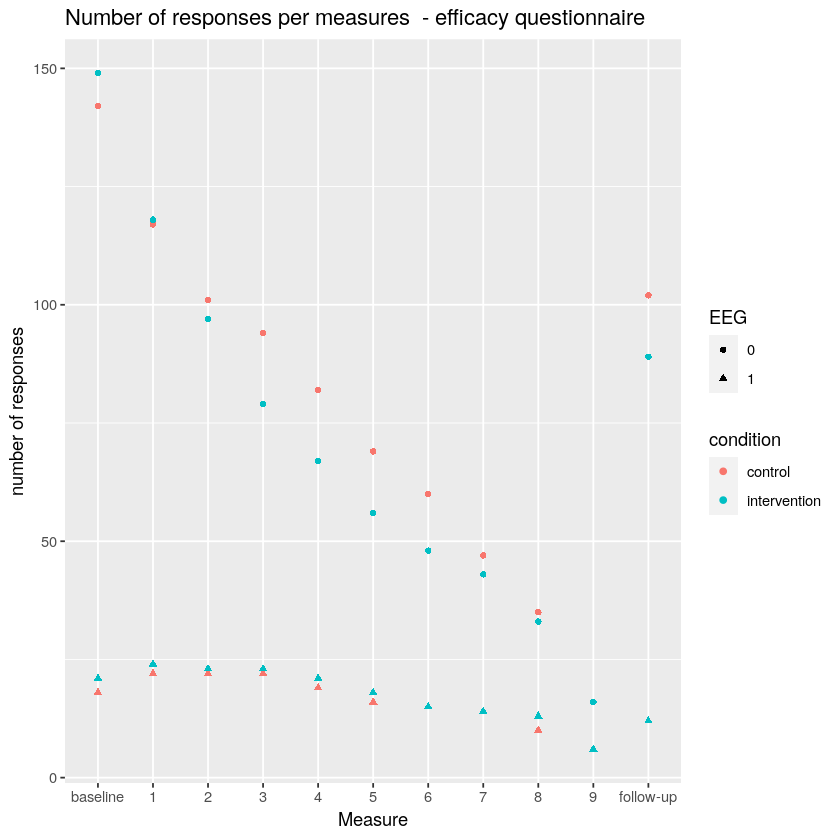

In [75]:
n_rep <- df %>% group_by(condition, n_day, EEG) %>%
 summarize(count=n()) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()

n_rep$EEG<-as.factor(n_rep$EEG)


# plot
ggplot(data= n_rep, aes(x = n_day, y=count)) +
  geom_point(mapping = aes(colour = condition, shape =EEG ) ) +
  ggtitle("Number of responses per measures  - efficacy questionnaire")+
  xlab('Measure')+ ylab('number of responses')+ 
 ggsave('nresp_per_day.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

Work on scores for self, response and hope

In [76]:
colnames(df)

[1] "ID"        "Good"      "condition" "EEG"       "date"      "r_eff1"   
 [7] "r_eff2"    "s_eff1"    "s_eff2"    "s_eff3"    "hope"      "type"     
[13] "n_day"

In [77]:
# take the score of each (resp and self) item for each day for each pp

df<- df %>% 
         mutate(score_re= rowMeans(select(., c('r_eff1','r_eff2')), na.rm=TRUE) , 
         score_se= rowMeans(select(., c('s_eff1', 's_eff2', 's_eff3')), na.rm=TRUE), 
         score_hope= rowMeans(select(., c('hope')), na.rm=TRUE)        
         ) 
    

In [ ]:
df

In [78]:
df2<-select(df, -"r_eff1", -"r_eff2", -"s_eff1", -"s_eff2", -"s_eff3", -"hope")

In [ ]:
#df2<- rename(df2, total_hope=hope)

In [ ]:
#df2<-select(df2, -'Good', -'EEG', -'date')

In [79]:
head(df2)

ID,Good,condition,EEG,date,type,n_day,score_re,score_se,score_hope
<chr>,<dbl>,<chr>,<dbl>,<dttm>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
702,1,intervention,0,2019-07-16 00:48:54,every3days,1,70,70.00000,73
702,1,intervention,0,2019-07-21 23:27:25,every3days,2,100,71.33333,76
702,1,intervention,0,2019-07-25 01:59:41,every3days,3,76,85.66667,75
702,1,intervention,0,2019-07-28 01:49:46,every3days,4,81,69.33333,76
702,1,intervention,0,2019-08-03 15:02:46,every3days,5,85,88.66667,80
702,1,intervention,0,2019-08-06 01:51:27,every3days,6,92,90.33333,84


In [80]:
# turn df into long format 
df2_long<-df2 %>% 
  pivot_longer(
    -c('ID', 'condition','type', 'n_day', 'Good', 'EEG', 'date'),  
    names_to = c(".value", "value"), 
    names_sep = "_", 
    values_drop_na = TRUE
  )

In [81]:
df2_long$EEG<-as.factor(df2_long$EEG)

In [82]:
# compute summary statistics per condition per day for each score
summary_df2 <- df2_long %>%
  group_by(condition, n_day, value) %>%
  summarise(mean.score = mean(score),
            sd.score= sd(score), count = n(),
            se.mean = sd.score/sqrt(count), 
            ci.mean= qt(1-(1-0.95/2),count-1)*se.mean)

In [83]:
summary_df2  %>% filter(n_day == 'baseline')

condition,n_day,value,mean.score,sd.score,count,se.mean,ci.mean
<chr>,<fct>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
control,baseline,hope,34.20388,25.45175,103,2.507835,-0.1576457
control,baseline,re,62.77670,23.32515,103,2.298295,-0.1444737
control,baseline,se,35.05987,25.29314,103,2.492207,-0.1566633
intervention,baseline,hope,35.85714,22.67133,105,2.212495,-0.1390736
intervention,baseline,re,69.22381,25.15032,105,2.454419,-0.1542806
intervention,baseline,se,36.35238,21.95712,105,2.142795,-0.1346924


In [84]:
head(summary_df2)

condition,n_day,value,mean.score,sd.score,count,se.mean,ci.mean
<chr>,<fct>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
control,baseline,hope,34.20388,25.45175,103,2.507835,-0.1576457
control,baseline,re,62.77670,23.32515,103,2.298295,-0.1444737
control,baseline,se,35.05987,25.29314,103,2.492207,-0.1566633
control,1,hope,39.68345,25.50221,139,2.163069,-0.1358860
control,1,re,65.22662,23.06255,139,1.956140,-0.1228865
control,1,se,40.13669,25.83968,139,2.191693,-0.1376842



- 3. Compute mean response and self efficacy score for each day for each pp

- 4. plot
!!! different number of data points per paricipant !!!

# test plot

https://stackoverflow.com/questions/55262229/how-to-use-geom-errorbar-with-facet-wrap-in-ggplot2

In [ ]:
#write_csv(m_scores, "summary_stats.csv")

Plot response and self efficacy scores

In [85]:
test_eff<-summary_df2 %>% 
        filter(value=="re" | value=="se") 

Saving 6.67 x 6.67 in image



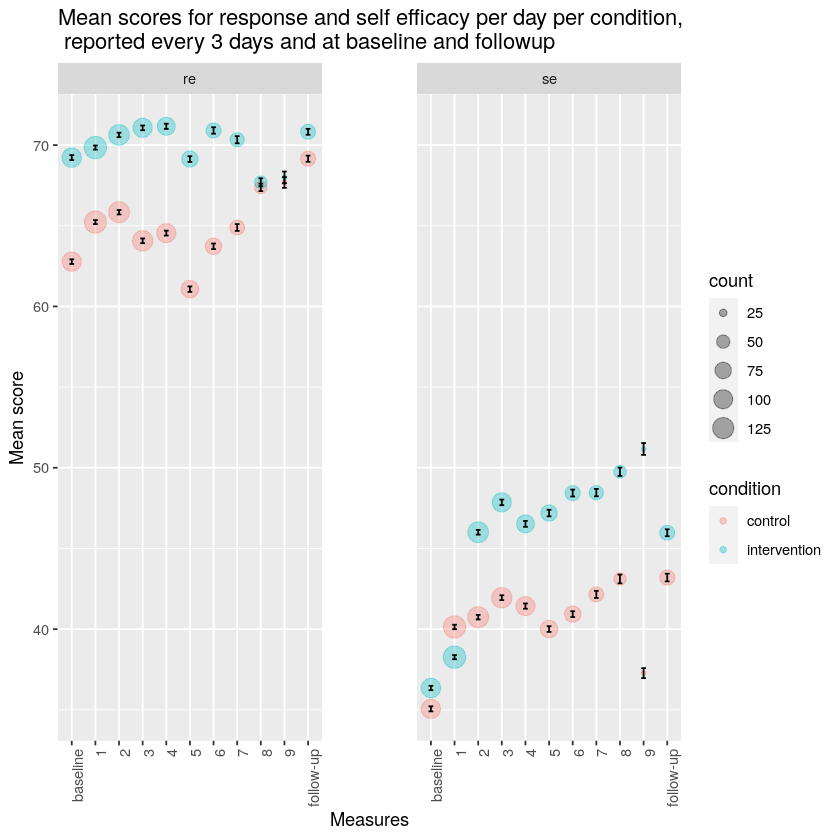

In [86]:
gs1 <- ggplot(test_eff, aes(x=n_day, y=mean.score)) + 
       geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
       facet_wrap(~value)+
       geom_errorbar(aes(ymin = mean.score - ci.mean, ymax = mean.score + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
    ggtitle("Mean scores for response and self efficacy per day per condition,\n reported every 3 days and at baseline and followup")
gs1 + theme(panel.spacing.x=unit(2, "cm"),panel.spacing.y=unit(1, "lines")) +
 theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave('efficacy_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)

Seems like scores were quite high to start with for response efficacy, maybe a plateau effect while self efficacy scores were lower at baseline

Plot hope score

In [87]:
test_hope<-summary_df2 %>% 
        filter(value=="hope")  

In [ ]:
test_hope

Saving 6.67 x 6.67 in image



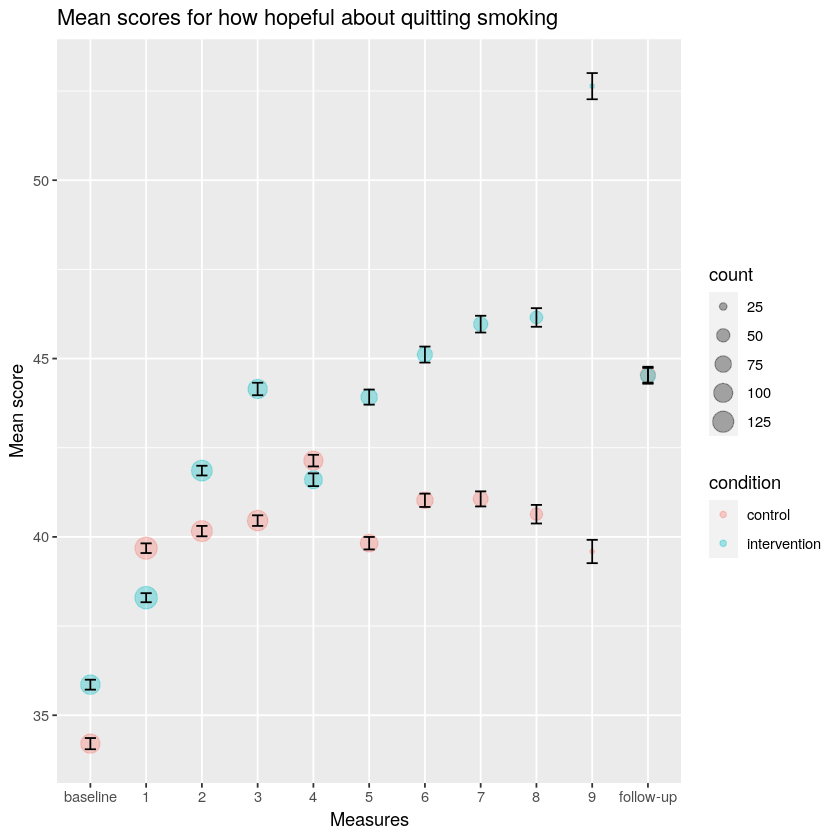

In [88]:

ggplot(data=test_hope, mapping=aes(x= n_day, y=mean.score)) +
      geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
       geom_errorbar(aes(ymin = mean.score - ci.mean, ymax = mean.score + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
   ggtitle("Mean scores for how hopeful about quitting smoking")

  ggsave('hope_scores_v2.jpg', plot =last_plot(), dpi =300, path= save_figure)


Make raincloud plots

In [89]:
library(cowplot)
library(readr)

source("~/Documents/RainCloudPlots/tutorial_R/R_rainclouds.R")
source("~/Documents/RainCloudPlots/tutorial_R/summarySE.R")

theme_set(theme_cowplot())


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [ ]:
packages <- c("ggplot2", "dplyr", "lavaan", "plyr", "cowplot", "rmarkdown",
"readr", "caTools", "bitops")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
install.packages(setdiff(packages, rownames(installed.packages())))
}

In [ ]:
df3<-df2

In [ ]:
which(is.na(df3$n_day))

In [ ]:
colnames(df3)

In [ ]:
df3<-drop_na(df3, n_day)

In [ ]:
 ggplot(df3, aes(x = n_day, y = score_se, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = score_se, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = score_se,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Self-efficacy score") +
  coord_flip()

ggsave('raincloud_self_eff_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
ggplot(df3, aes(x = n_day, y = score_re, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = score_re, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = score_re,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  #scale_colour_manual(values=cbPalette)+
  #scale_fill_manual(values=cbPalette)+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Response-efficacy score") +
  coord_flip()

ggsave('raincloud_resp_eff_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
ggplot(df3, aes(x = n_day, y = score_hope, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = score_hope, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = score_hope,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Hope score") +
  coord_flip()

ggsave('raincloud_hope_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
colnames(df3)